In [6]:
%pip install fastf1


In [7]:
import fastf1 as ff1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Enable FastF1 caching to speed up data loading
ff1.Cache.enable_cache('f1_cache')

NotADirectoryError: Cache directory does not exist! Please check for typos or create it first.

In [11]:
# Load the race session for the 2024 Brazilian GP
YEAR = 2025
RACE = 'Hungary'
SESSION = 'R'
race = ff1.get_session(YEAR, RACE, SESSION)
race.load()

core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Hungarian Grand Prix - Race [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_stat

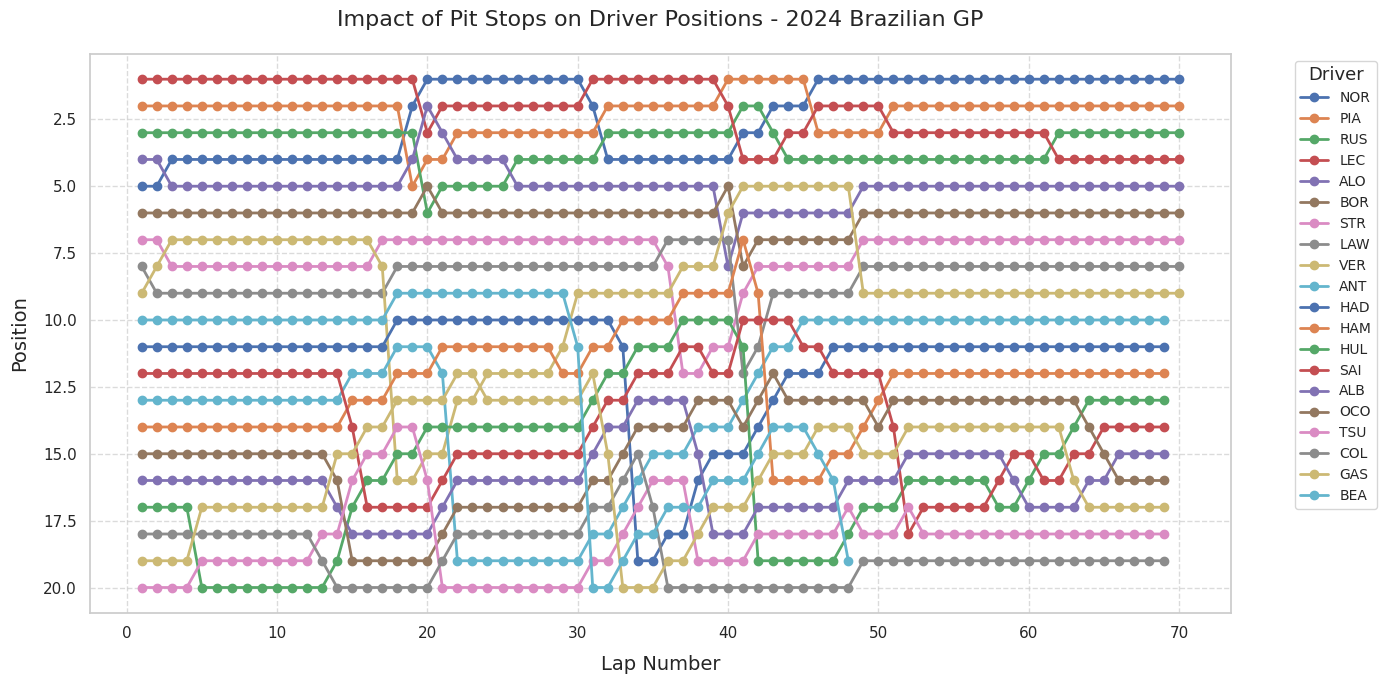

In [12]:
# Extract the race results and get the list of all drivers
results = race.results
all_drivers = results['Abbreviation'].tolist()  # Get all driver abbreviations

# Extract all laps data
laps = race.laps

# Filter laps for pit stops by all drivers
pit_stops = laps[(laps['PitInTime'].notna()) & (laps['Driver'].isin(all_drivers))]

# Make a copy of the filtered DataFrame to avoid SettingWithCopyWarning
pit_stop_df = pit_stops[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound']].copy()

# Calculate pit stop duration in seconds
pit_stop_df['PitStopDuration'] = (pit_stop_df['PitOutTime'] - pit_stop_df['PitInTime']).dt.total_seconds()

# Drop rows with any NaN values in important columns
pit_stop_df = pit_stop_df.dropna(subset=['PitStopDuration', 'Compound'])

# Set up seaborn style
sns.set(style='whitegrid')

# Extract positions for all drivers to analyze pit stop impact
driver_positions = laps[laps['Driver'].isin(all_drivers)][['Driver', 'LapNumber', 'Position']].copy()

# Plot: Impact of Pit Stops on Positions for All Drivers
plt.figure(figsize=(14, 7))

# Loop through each driver and plot their positions
for driver in all_drivers:
    driver_data = driver_positions[driver_positions['Driver'] == driver]
    plt.plot(driver_data['LapNumber'], driver_data['Position'],
             marker='o', label=driver,
             linewidth=2, markersize=6)  # Line and marker customization

    # Add pit stop markers for the current driver
    driver_pit_stops = pit_stop_df[pit_stop_df['Driver'] == driver]
    for pit_stop in driver_pit_stops['LapNumber']:
        plt.plot(pit_stop, driver_data[driver_data['LapNumber'] == pit_stop]['Position'].values[0],
                 marker='x', color='red', markersize=8, label=f'{driver} Pit Stop' if pit_stop == driver_pit_stops['LapNumber'].iloc[0] else "")

# Invert the y-axis because lower position numbers are better
plt.gca().invert_yaxis()

# Customize labels and title with larger fonts
plt.xlabel('Lap Number', fontsize=14, labelpad=10)
plt.ylabel('Position', fontsize=14, labelpad=10)
plt.title('Impact of Pit Stops on Driver Positions ', fontsize=16, pad=20)

# Customize the legend
plt.legend(title='Driver', title_fontsize=13, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add gridlines with a subtle style
plt.grid(True, linestyle='--', alpha=0.7)

# Improve layout for readability and to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()